In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [25]:
from kerastuner.tuners import RandomSearch

# Specify each path

In [26]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.h5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [27]:
NUM_CLASSES = 0
with open('model/keypoint_classifier/keypoint_classifier_label.csv',encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    data = list(reader)
    NUM_CLASSES = len(data)
print(NUM_CLASSES)

39


# Dataset reading

In [28]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (42 * 2) + 1)))

In [29]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.85, random_state=RANDOM_SEED)

# Keras Tuner

In [31]:
def build_model(hp):
    model = tf.keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(tf.keras.layers.Input((42 * 2, ))),
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')),
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [37]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner',
    project_name='signlanguagehyperprameters',
	overwrite=True)

In [38]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [39]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 04m 20s]
val_accuracy: 0.9796073039372762

Best val_accuracy So Far: 0.9928739269574484
Total elapsed time: 00h 20m 50s
INFO:tensorflow:Oracle triggered exit


In [59]:
model = tuner.get_best_models(num_models=1)[0]
model.build()

In [66]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [67]:
model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=1000,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback],
)

Epoch 1/1000
389/390 [============================>.] - ETA: 0s - loss: 0.2441 - accuracy: 0.0000e+00
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.h5
390/390 [==============================] - 6s 9ms/step - loss: 0.2439 - accuracy: 0.0000e+00 - val_loss: 0.0300 - val_accuracy: 0.0000e+00
Epoch 2/1000
388/390 [============================>.] - ETA: 0s - loss: 0.0453 - accuracy: 0.0000e+00
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.h5
390/390 [==============================] - 3s 8ms/step - loss: 0.0452 - accuracy: 0.0000e+00 - val_loss: 0.0247 - val_accuracy: 0.0000e+00
Epoch 3/1000
383/390 [============================>.] - ETA: 0s - loss: 0.0218 - accuracy: 2.0398e-05
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.h5
390/390 [==============================] - 3s 8ms/step - loss: 0.0215 - accuracy: 2.0069e-05 - val_loss: 0.0181 - val_accuracy: 3.4114e-04
Epoch 4/1000
 80/390 [=====>........................] -

KeyboardInterrupt: 

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 384)               32640     
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 512)               197120    
                                                                 
 input_3 (InputLayer)        multiple                  0         
                                                                 
 dense_2 (Dense)             (None, 32)                16416     
                                                                 
 input_4 (InputLayer)        multiple                  0         
                                                                 
 dense_3 (Dense)             (None, 32)                1

In [47]:
tuner.results_summary()

Results summary
Results in tuner\signlanguagehyperprameters
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
num_layers: 18
units_0: 384
units_1: 512
learning_rate: 0.001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
units_14: 32
units_15: 32
units_16: 32
units_17: 32
Score: 0.9928739269574484

Trial 3 summary
Hyperparameters:
num_layers: 18
units_0: 384
units_1: 224
learning_rate: 0.0001
units_2: 32
units_3: 160
units_4: 160
units_5: 416
units_6: 64
units_7: 32
units_8: 352
units_9: 448
units_10: 512
units_11: 96
units_12: 320
units_13: 384
units_14: 288
units_15: 416
units_16: 384
units_17: 64
Score: 0.9910545150438944

Trial 1 summary
Hyperparameters:
num_layers: 15
units_0: 32
units_1: 256
learning_rate: 0.001
units_2: 64
units_3: 96
units_4: 384
units_5: 384
units_6: 288
units_7: 224
units_8: 320
units_9: 128
units_10: 416
un

In [61]:
model.save(model_save_path)

# Model Evaluation

In [62]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

69/69 [==============================] - 1s 4ms/step - loss: 0.0403 - accuracy: 0.0000e+00


In [63]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [64]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))
x = np.argmax(np.squeeze(predict_result))
print(np.squeeze(predict_result)[x])

1/1 [==============================] - 0s 345ms/step
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7995782e-22 0.0000000e+00
 1.9971092e-36 0.0000000e+00 0.0000000e+00 1.9071398e-12 1.5795353e-22
 0.0000000e+00 1.6210498e-38 0.0000000e+00 0.0000000e+00 4.8547968e-38
 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.6663771e-26 3.7220445e-24
 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 1.0619244e-35
 6.6664239e-22 1.8927181e-11 0.0000000e+00 0.0000000e+00]
31
1.0


# Confusion matrix

275/275 [==============================] - 1s 3ms/step


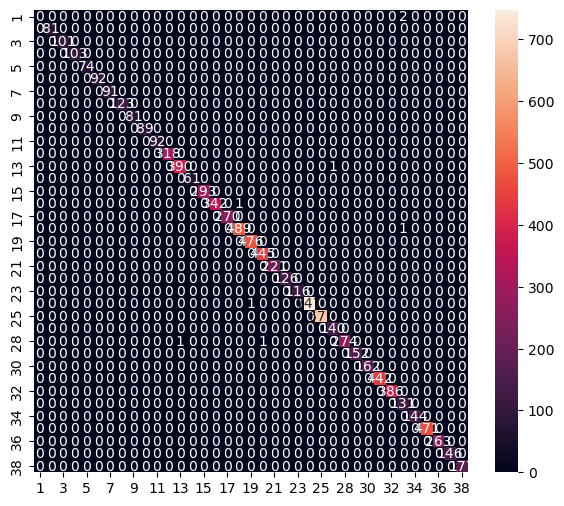

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00        81
           3       1.00      1.00      1.00       101
           4       1.00      1.00      1.00       103
           5       1.00      1.00      1.00        74
           6       1.00      1.00      1.00        92
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00       123
           9       1.00      1.00      1.00        81
          10       1.00      1.00      1.00        89
          11       1.00      1.00      1.00        92
          12       1.00      1.00      1.00       318
          13       1.00      1.00      1.00       391
          14       1.00      1.00      1.00        61
          15       1.00      1.00      1.00       293
          16       1.00      1.00      1.00       343
          17       1.00      1.00      1.00       270
     

C:\Users\kaka1\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kaka1\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kaka1\anaconda3\envs\project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [689]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [690]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [691]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\kaka1\AppData\Local\Temp\tmp4w5s5by9\assets


INFO:tensorflow:Assets written to: C:\Users\kaka1\AppData\Local\Temp\tmp4w5s5by9\assets


197216

# Inference test

In [692]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [693]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [694]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [695]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [696]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 2.9059917e-33 1.9456911e-26 0.0000000e+00 0.0000000e+00
 4.9792880e-20 1.3052529e-35 0.0000000e+00 7.4683015e-19 6.5726707e-28
 4.9367810e-31 0.0000000e+00 1.0644434e-27 6.1413950e-15 1.1411938e-25
 2.4360953e-37 9.9707608e-28 7.3714093e-36 0.0000000e+00 6.6033959e-31
 2.4571391e-31 2.2331268e-36 4.4101075e-28 2.3092302e-37 9.2326559e-32
 2.1591247e-15 1.0000000e+00 0.0000000e+00 3.6915378e-20 0.0000000e+00
 3.6246667e-36 0.0000000e+00 0.0000000e+00 1.1754944e-38]
31
